In [1]:
import pandas as pd
import numpy as np
# read the data
raw_data=pd.read_csv('preparation_data.csv')


In [2]:
Immune_cells=['Tn', 'Th', 'Tc', 'Tr', 'Dn', 'D', 'M', 'M0']
IC_variable_list=['Tn', 'Th', 'Tc', 'Tr', 'Dn', 'D', 'M', 'C', 'N', 'mu1', 'mu2',
       'H', 'Ig', 'Gb']

model_cells=['Tn', 'Th', 'Tc', 'Tr', 'Dn', 'D', 'M','Cluster']

In [3]:
# rearrange the data corresponding to variables
full_data=pd.DataFrame()
full_data['Sample ID']=raw_data['Sample ID']
full_data['Tn']=raw_data[['T cells CD4 naive', 'T cells CD4 memory resting', 'NK cells resting']].sum(axis=1)
full_data['Th']=raw_data['T cells CD4 memory activated']+raw_data['T cells follicular helper']
full_data['Tc']=raw_data['T cells CD8']+raw_data['NK cells activated']
full_data['Tr']=raw_data['T cells regulatory (Tregs)']
full_data['Dn']=raw_data['Dendritic cells resting']
full_data['D']=raw_data['Dendritic cells activated']
full_data['M']=raw_data['Macrophages M1']+raw_data['Macrophages M2']
full_data['M0']=raw_data[['Monocytes', 'Macrophages M0', 'Macrophages M1', 'Macrophages M2']].sum(axis=1)
full_data['C']=""
full_data['N']=""
full_data['mu1']=raw_data[['IL6', 'IL17A', 'IL17B', 'IL17C', 'IL17D', 'IL17F', 'IL21', 'IL22']].sum(axis=1)
full_data['mu2']=raw_data['CCL20']+raw_data['IL10']
full_data['H']=raw_data['HMGB1']
full_data['Ig']=raw_data['IFNG']
full_data['Gb']=raw_data[['TGFB1', 'TGFB1I1', 'TGFB2', 'TGFB3', 'TGFBI']].sum(axis=1)
full_data['Cluster']=raw_data['Cluster']+1
full_data['dim']=raw_data['multiply_dimensions']
full_data['necrosis_percent']=raw_data['necrosis_percent']
full_data['TIC']=full_data[['Tn', 'Th', 'Tc', 'Tr','Dn', 'D', 'M0']].sum(axis=1)


#Substitute zeros with something negligibly small, but positive
mincellvalue=full_data[Immune_cells].to_numpy()[:]
mincellvalue=mincellvalue[mincellvalue>0].min()
for key in Immune_cells:
    full_data.loc[full_data[key]<=0, key]=0.1*mincellvalue

In [4]:
model_cell=full_data[model_cells]
model_cell=model_cell.sort_values(by=['Cluster'])
model_cell.head()

,Tn,Th,Tc,Tr,Dn,D,M,Cluster
0,0.159096,0.158013,0.074747,0.015229,0.005021,0.014164,0.298423,1
84,0.242261,0.081222,0.112084,0.049170,0.000003,0.022073,0.098106,1
83,0.382441,0.095423,0.000003,0.033369,0.000003,0.010879,0.138703,1
82,0.310293,0.007159,0.000003,0.023875,0.000003,0.018469,0.185445,1
81,0.245870,0.038709,0.131035,0.056815,0.000003,0.000003,0.238596,1


In [5]:
df_mean = model_cell.groupby('Cluster').mean().reset_index()
df_mean

,Cluster,Tn,Th,Tc,Tr,Dn,D,M
0,1,0.271468,0.089982,0.052811,0.048625,0.005607,0.011594,0.207890
1,2,0.202401,0.119799,0.124148,0.059940,0.003465,0.011295,0.159007
2,3,0.153474,0.040201,0.016051,0.047240,0.000329,0.003556,0.143977
3,4,0.315413,0.055038,0.053538,0.047862,0.009981,0.014374,0.219494
4,5,0.204511,0.068115,0.030012,0.049702,0.001634,0.008108,0.201331


<function matplotlib.pyplot.show(*args, **kw)>

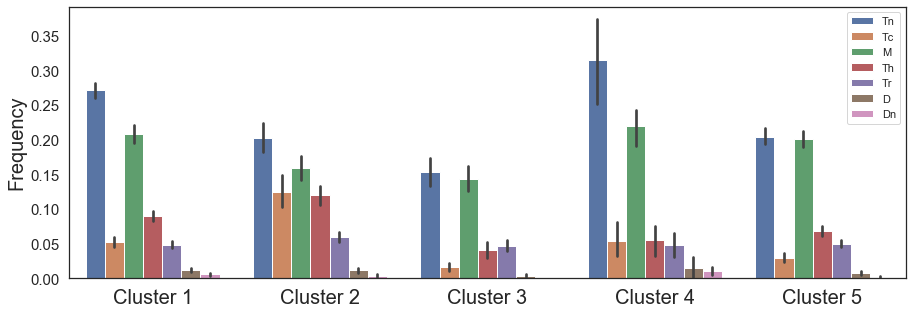

In [6]:
# Calculate variables with largest differences (by standard deviation)
# The higher the standard deviation in a variable based on average values for each cluster
# The more likely that the variable is important when creating the cluster
import seaborn as sns
import matplotlib.pylab as plt
sns.set(style="white")

results = pd.DataFrame(columns=['Variable', 'Std'])
for column in df_mean.columns[1:]:
    results.loc[len(results), :] = [column, np.std(df_mean[column])]
selected_columns = list(results.sort_values('Std', ascending=False).head(7).Variable.values) + ['Cluster']

# Plot data

melted_data = model_cell[selected_columns].melt(id_vars='Cluster')
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='Cluster', y='value', hue='variable',data=melted_data)
plt.legend(loc='best')
ax.tick_params(labelsize=15)

plt.xlabel('')
plt.ylabel('Frequency',size=20)
positions = (0,1,2,3,4)
labels = ("Cluster 1", "Cluster 2", "Cluster 3",'Cluster 4','Cluster 5')
plt.xticks(positions, labels,size=20)
#plt.savefig("model_cell_cluster.eps",format='eps',bbox_inches='tight', dpi=1000)

plt.show

In [7]:
full_data=full_data[~full_data.dim.isnull()]
full_data.shape

(216, 20)

In [8]:
# Mean tumor dimension global and for each cluster
meandim=np.empty(6)
meandim[0]=full_data['dim'].mean()
for i in range(5):
    meandim[i+1]=full_data[full_data['Cluster']==i+1]['dim'].mean()
meandim


array([0.63578704, 0.64154762, 0.7062069 , 0.63555556, 0.68666667,
       0.6       ])

In [9]:
# Mean total immune cell count global and for each cluster
meanTIC=np.empty(6)
meanTIC[0]=full_data['TIC'].mean()
for i in range(5):
    meanTIC[i+1]=full_data[full_data['Cluster']==i+1]['TIC'].mean()
meanTIC

array([0.8523155 , 0.85867209, 0.79957819, 0.87724376, 0.79323394,
       0.8637232 ])

In [10]:
full_data['CI_percent']=1-full_data[['necrosis_percent']]
av=full_data['CI_percent'].mean()
avN=full_data['necrosis_percent'].mean()
avC=(2*av)/3
aVI=av/3
print(avC)
print(aVI)
print(avN)
#total cell density from size of tumor:
full_data['TCD']=full_data['dim']*(4.5e4/0.6/meandim[0])

0.6196913580246909
0.30984567901234544
0.07046296296296298


In [11]:
#multiply TCD with percent of necrosis to find Necrosis count:
full_data.N=full_data.TCD*full_data.necrosis_percent
#TCD=C+I+N
# assume C=2I so TCD*(cancer+ imuune cell percent )=C+C/2:
full_data.C=2*((full_data.TCD*full_data.CI_percent)/3)
full_data['I']=full_data.C/2
for key in Immune_cells:
    #multiply immunes ratio with calculated total immune count
    full_data[key]=full_data[key]*full_data['I']
    
full_data[Immune_cells].head(5)


,Tn,Th,Tc,Tr,Dn,D,M,M0
0,3565.839533,3541.572889,1675.322520,341.331440,112.529645,317.466081,6688.595151,9336.162637
1,1957.012999,1071.605883,646.606614,757.432326,0.032606,74.850973,1265.685046,2988.857964
2,5024.657494,3095.059911,947.948928,768.775536,269.119288,176.088066,4929.248353,9244.498987
3,13627.619968,684.305848,643.938553,2204.774360,741.126443,316.066020,4646.140468,7884.730613
4,1926.553176,595.502563,183.312456,154.389696,0.023467,63.427918,987.533603,2157.622996


In [12]:
scale=pd.read_csv('Large_Tumor_variable_scaling.csv')
scale

,Tn,Th,Tc,Tr,Dn,D,M,C,N,mu1,mu2,H,Ig,Gb
0,14913.620811,4635.773151,2584.503418,2389.138433,305.044967,602.140220,11797.958248,91530.649362,45765.324681,163.282032,1298.739602,8981.057269,8.573659,19037.039520
1,11429.396641,6041.089213,5385.336010,3364.597482,103.286435,512.994704,8622.655477,97064.422258,48532.211129,175.520039,1324.901879,8527.861578,10.567708,22274.518884
2,9238.125785,1386.424586,1113.864264,2791.025543,0.188776,186.354105,6797.243406,90028.996159,45014.498079,198.663632,1290.613963,9512.197906,0.828700,25145.441463
3,13877.877977,2491.045227,3217.195647,2278.338057,141.957314,621.536542,12931.023775,96955.585442,48477.792721,114.100079,336.885863,5178.201583,1.270269,8173.415225
4,10261.828307,3784.424093,1685.327950,2639.354792,80.198887,190.838162,11602.523814,80583.525932,40291.762966,120.582434,715.505701,7784.776714,5.789200,26259.619112


In [13]:
Small_tumor_data=pd.DataFrame()
#No_tumor_data=pd.DataFrame()
IC_data=pd.DataFrame()
for i in range(5):
    tmp=pd.DataFrame()
    tmp=full_data.loc[((full_data['Cluster']==i+1) & ((full_data['dim']<meandim[i+1])|(full_data['dim'].isnull()))), IC_variable_list+['Cluster']]
    tmp.loc[:, IC_variable_list]/=scale.loc[i, IC_variable_list]
    Small_tumor_data=Small_tumor_data.append(tmp, ignore_index=True)

    IC_data=IC_data.append(full_data.loc[full_data.loc[(full_data['Cluster']==i+1),'dim'].idxmin(), IC_variable_list]/
                           scale.loc[i,IC_variable_list], ignore_index=True)


#IC_data[IC_variable_list].to_csv('New_Initial_Conditions.csv', index=False)
IC_data

,C,D,Dn,Gb,H,Ig,M,N,Tc,Th,Tn,Tr,mu1,mu2
0,0.046397,0.000012,0.064097,0.254898,1.471228,3.889160,0.026446,0.015466,0.096672,0.049039,0.036552,0.026975,0.497087,0.512430
1,0.023820,0.059463,0.043730,0.556563,0.603594,0.938493,0.027612,0.001458,0.032508,0.028115,0.026292,0.010914,0.757817,0.178951
2,0.183440,0.261119,0.152661,3.869126,1.030247,0.490399,0.156238,0.000000,0.085937,0.219600,0.137893,0.062557,0.751181,0.713903
3,0.121668,0.468290,0.619655,2.562888,1.463045,0.000000,0.100959,0.000000,0.063495,0.017129,0.157801,0.097161,0.413658,5.772001
4,0.026935,0.009113,0.000047,0.345662,1.183454,0.408356,0.015548,0.007027,0.032691,0.052405,0.013631,0.037758,0.458708,2.297909
